In [1]:
from __future__ import division
import pandas as pd
import pandas_datareader as pdr
import numpy as np
from numpy.linalg import inv,pinv
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
matplotlib.style.use('ggplot')

from performance import *
from risk_parity import *
from factor import *

# Purpose of the Notebook

Applying Factor Risk Parity on Bond Style Factors and Macro Factors

## Style factors risk parity - direct country allocation coming from factor construction

## Equity

In [2]:
equity_factors = pd.read_pickle('../Outputs/equity/equity_country_factors_rf.pkl')
equity_factors = equity_factors[equity_factors.momentum.notnull()]
equity_bnch = equity_factors[['market-rf']]
equity_rf = equity_factors['rf']
equity_factors.drop(columns=['market-rf', 'rf'], inplace=True)
equity_country_returns = pd.read_pickle('../Outputs/equity/equity_etf_returns_weekly.pkl')


bond_factors = pd.read_pickle('../Outputs/bond/bond_country_factors.pkl')
bond_macro_factors = pd.read_pickle('../Outputs/bond/bond_macro_factors.pkl')
bond_bnch = pd.read_pickle('../Outputs/bond/bond_benchmark_ret.pkl')
bond_rf = pd.read_pickle('../Outputs/bond/bond_risk_free.pkl')['3M_libor']
bond_country_returns = pd.read_pickle('../Outputs/bond/bond_country_returns.pkl')

In [3]:
equity_factor_rp_rebal = RiskParity(aum=1, 
                                    asset_names=equity_factors.columns, 
                                    returns=equity_factors, 
                                    target_vol=5,
                                    time=52, 
                                    burn=52)

equity_factor_rp_trade, equity_factor_rp_trade_pct, equity_factor_rp_weight, equity_factor_rp_returns = equity_factor_rp_rebal.get_flow()

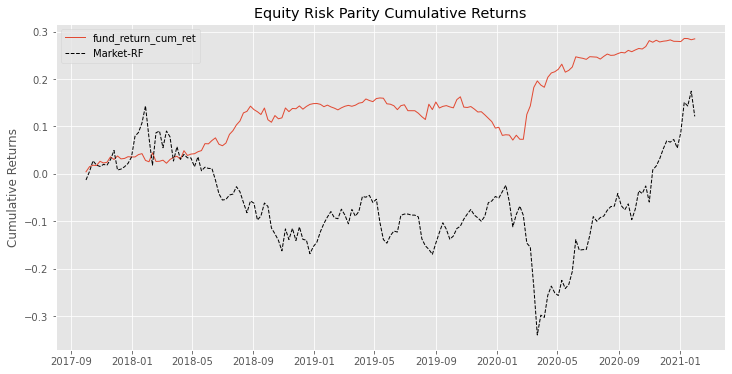

In [4]:
equity_factors_rp_cum_ret = calc_cum_returns(equity_factor_rp_returns)
equity_bnch_cum_ret = calc_cum_returns(equity_bnch.loc[equity_factor_rp_returns.index])

# Plot cumulative returns
plot_perf(perf=[equity_factors_rp_cum_ret[x] for x in list(equity_factors_rp_cum_ret.columns.values)],
          perf_bm=equity_bnch_cum_ret,
          label=equity_factors_rp_cum_ret.columns,
          title='Equity Risk Parity Cumulative Returns')

## Bond

In [5]:
bond_factor_rp_rebal = RiskParity(aum=1, 
                                  asset_names=bond_factors.columns, 
                                  returns=bond_factors, 
                                  target_vol=10,
                                  time=12,
                                  burn=12)

bond_factor_rp_trade, bond_factor_rp_trade_pct, bond_factor_rp_weight, bond_factor_rp_returns = bond_factor_rp_rebal.get_flow()

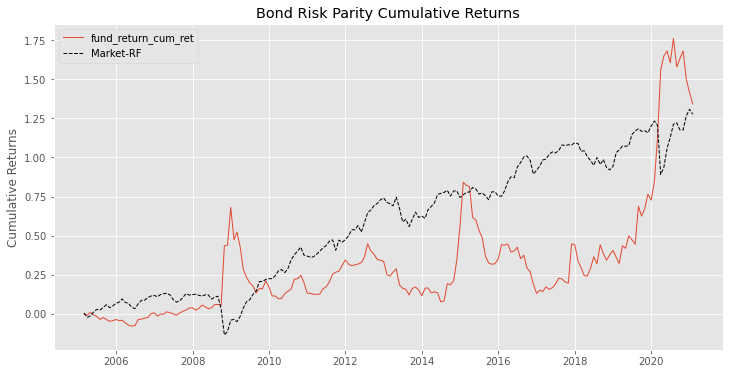

In [6]:
bond_factors_rp_cum_ret = calc_cum_returns(bond_factor_rp_returns)
bond_bnch_cum_ret = calc_cum_returns(bond_bnch.loc[bond_factor_rp_returns.index])

# Plot cumulative returns
plot_perf(perf=[bond_factors_rp_cum_ret[x] for x in list(bond_factors_rp_cum_ret.columns.values)],
          perf_bm=bond_bnch_cum_ret,
          label=bond_factors_rp_cum_ret.columns,
          title='Bond Risk Parity Cumulative Returns')

## Macro factors - country allocation coming from rolling exposure to macro factors

In [7]:
def get_rolling_country_factor_beta(country_returns, factors, bnch, rf, window):

    rolling_betas = {}

    for c in country_returns:
        y = country_returns.loc[factors.index][c]
        y = y - rf
        y = y.dropna()
        X = pd.concat([factors.loc[y.index], bnch.loc[y.index]], axis=1)
        X = sm.add_constant(X, prepend=False)
        mod = RollingOLS(y, X,window=window)
        rolling_res = mod.fit(params_only=True)
        rolling_betas[c] = rolling_res.params
    rolling_df = pd.concat(rolling_betas)

    time_list = rolling_df.index.get_level_values(1).unique()

    exposure, cov = {}, {}
    factor_rolling_cov = factors.rolling(window, min_periods = 1).cov()
    for m in time_list:
        temp_df = rolling_df.loc[(slice(None), m), :].iloc[:,:-1]
        exposure[m] = temp_df
        cov[m] = factor_rolling_cov.loc[(m,slice(None)), :]
        
    return exposure, cov

In [24]:
def get_country_allocation(exposure, cov, rp_weight, country_returns):
    
    container = {}
    time_in_common = set(cov.keys()).intersection(rp_weight.index)
    realized_weights_cols = rp_weight.columns[rp_weight.columns.str.startswith('real')]
    
    for m in time_in_common:

            factor_weights = rp_weight[realized_weights_cols].loc[m].values
            if 'bnch' in exposure[m].columns:
                exposure_temp = exposure[m].drop(columns=['bnch'])
            elif 'market-rf' in exposure[m].columns:
                exposure_temp = exposure[m].drop(columns=['market-rf'])
            else:
                exposure_temp = exposure[m]
            exposure_temp = exposure_temp.droplevel(level=1, axis=0)
            # port_ret, port = construct_factor(exposure_temp, country)
            country_weights = exposure_temp.values @ factor_weights.T
            if not np.all(np.isnan(country_weights)):
                country_weights_df = pd.DataFrame(country_weights, index=exposure_temp.index, columns=['Weights'])
                container[m] = country_weights_df


    # unnormalized weights
    rp_raw = pd.concat(container).reset_index().pivot(columns='level_1', index='level_0')
    rp_raw.plot(legend=False)
    

    rp_raw = rp_raw.div(rp_raw.abs().sum(axis=1), axis=0)
    country_rp = country_returns.loc[rp_raw.index] * rp_raw['Weights']
    country_rp_port = pd.DataFrame(country_rp.sum(axis=1), columns=['risk_parity'], index=rp_raw.index)
    
    return rp_raw, country_rp, country_rp_port

## Bond

In [9]:
bond_macro_factor_rp_rebal = RiskParity(aum=1, 
                                  asset_names=bond_macro_factors.columns, 
                                  returns=bond_macro_factors, 
                                  target_vol=10,
                                  time=12,
                                  burn=12)

bond_macro_factor_rp_trade, bond_macro_factor_rp_trade_pct, bond_macro_factor_rp_weight, bond_macro_factor_rp_returns = bond_macro_factor_rp_rebal.get_flow()

In [10]:
bond_exposure_monthly, bond_cov_monthly = get_rolling_country_factor_beta(bond_country_returns, bond_macro_factors, bond_bnch, bond_rf, window=12)

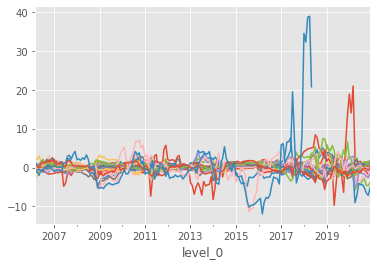

In [25]:
bond_country_weights, bond_country_rp_ret, bond_port_ret = get_country_allocation(bond_exposure_monthly, bond_cov_monthly, bond_macro_factor_rp_weight, bond_country_returns)

<AxesSubplot:title={'center':'total_weights'}, xlabel='level_0'>

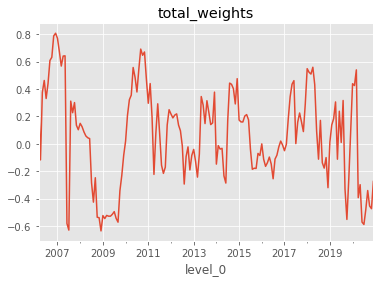

In [29]:
bond_country_weights.sum(axis=1).plot(title='total_weights')

<AxesSubplot:title={'center':'portfolio cumulative return'}, xlabel='level_0'>

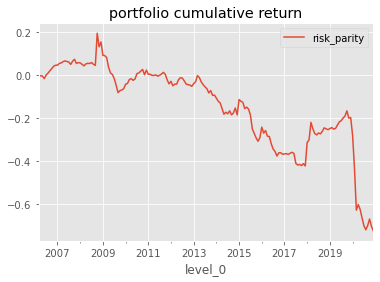

In [30]:
bond_port_ret.cumsum().plot(title='portfolio cumulative return')

## Equity

In [12]:
equity_exposure_weekly, equity_cov_weekly = get_rolling_country_factor_beta(equity_country_returns, equity_factors, equity_bnch, equity_rf, window=52)

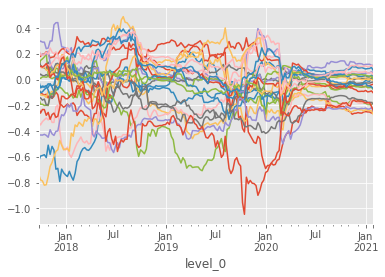

In [13]:
equity_country_weights, equity_country_rp_ret, equity_port_ret = get_country_allocation(equity_exposure_weekly, equity_cov_weekly, equity_factor_rp_weight, equity_country_returns)

<AxesSubplot:xlabel='level_0'>

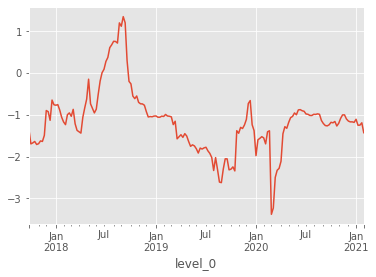

In [14]:
equity_country_weights.sum(axis=1).plot()

<AxesSubplot:xlabel='level_0'>

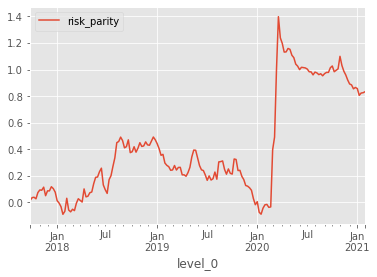

In [15]:
equity_port_ret.cumsum().plot()

## Exploratory - Try using beta exposure to macro factors to construct 1/3 long - 1/3 short factor portfolio on bonds - not working...

In [16]:
bond_exposure_df = pd.concat(bond_exposure_monthly).dropna()
credit_exposure = bond_exposure_df['credit'].reset_index(level=2, drop=True).unstack()
currency_exposure = bond_exposure_df['currency'].reset_index(level=2, drop=True).unstack()
equity_exposure = bond_exposure_df['equity'].reset_index(level=2, drop=True).unstack()
rates_exposure = bond_exposure_df['rates'].reset_index(level=2, drop=True).unstack()

In [17]:
credit_exposure_factor_ret, credit_exposure_factor_port = construct_factor(credit_exposure, bond_country_returns, ascending=False)
currency_exposure_factor_ret, currency_exposure_factor_port = construct_factor(currency_exposure, bond_country_returns, ascending=False)
equity_exposure_factor_ret, equity_exposure_factor_port = construct_factor(equity_exposure, bond_country_returns, ascending=False)
rates_exposure_factor_ret, rates_exposure_factor_port = construct_factor(rates_exposure, bond_country_returns, ascending=False)

In [18]:
macro_exposure_factors_ret = pd.concat([credit_exposure_factor_ret, currency_exposure_factor_ret, equity_exposure_factor_ret, rates_exposure_factor_ret], axis=1)
macro_exposure_factors = [x + '_exposure' for x in ['credit', 'currency', 'equity', 'rates']]
macro_exposure_factors_ret.columns = macro_exposure_factors

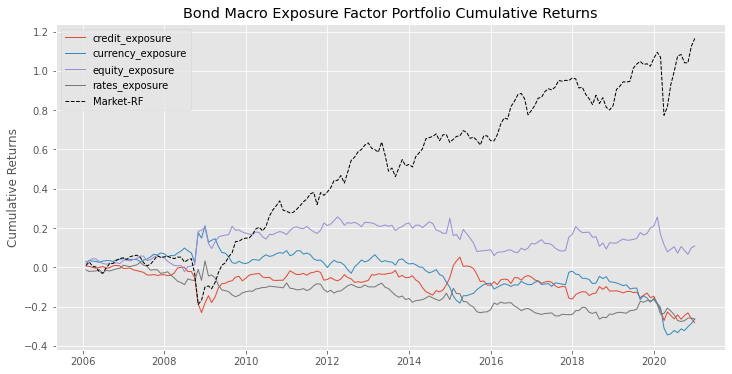

In [19]:
macro_exposure_factors_cum_ret = calc_cum_returns(macro_exposure_factors_ret)
bnch_excess_cum_ret = calc_cum_returns(bond_bnch.loc[macro_exposure_factors_ret.index])

# Plot cumulative returns
plot_perf(perf=[macro_exposure_factors_cum_ret[x] for x in list(macro_exposure_factors_cum_ret.columns.values)],
          perf_bm=bnch_excess_cum_ret,
          label=macro_exposure_factors_ret.columns, 
          title='Bond Macro Exposure Factor Portfolio Cumulative Returns')

In [20]:
bond_macro_exposure_factor_rp_rebal = RiskParity(aum=1, 
                                  asset_names=macro_exposure_factors_ret.columns, 
                                  returns=macro_exposure_factors_ret, 
                                  target_vol=10,
                                  time=12,
                                  burn=12)

bond_macro_exposure_factor_rp_trade, bond_macro_exposure_factor_rp_trade_pct, bond_macro_exposure_factor_rp_weight, bond_macro_exposure_factor_rp_returns = bond_macro_exposure_factor_rp_rebal.get_flow()

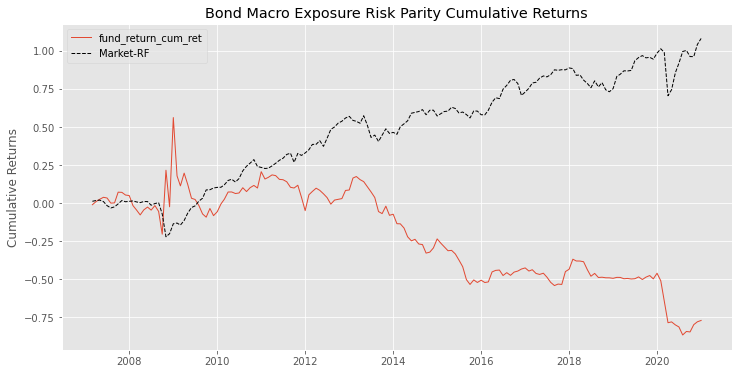

In [21]:
bond_macro_exposure_factors_rp_cum_ret = calc_cum_returns(bond_macro_exposure_factor_rp_returns)
bond_bnch_cum_ret = calc_cum_returns(bond_bnch.loc[bond_macro_exposure_factor_rp_returns.index])

# Plot cumulative returns
plot_perf(perf=[bond_macro_exposure_factors_rp_cum_ret[x] for x in list(bond_macro_exposure_factors_rp_cum_ret.columns.values)],
          perf_bm=bond_bnch_cum_ret,
          label=bond_macro_exposure_factors_rp_cum_ret.columns,
          title='Bond Macro Exposure Risk Parity Cumulative Returns')